## Training: Optimizers

### Introduction to Optimizers in Neural Networks

Optimizers in neural networks are algorithms or methods used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses. Optimization algorithms guide the training process towards the direction of minimum loss, or in other words, the best set of weights that represent the relationship between inputs and outputs.

#### Motivation and Intuition Behind Optimization

- **Why Optimization Matters:** The core objective of a neural network is to find the best possible values for its weights that minimize the loss function, leading to more accurate predictions. Optimization algorithms are the tools that make this search efficient and effective.

- **Stochastic Gradient Descent (SGD):** 
  - **Basic Concept:** SGD is the foundation of neural network optimization. It updates the weights incrementally after each iteration over a batch, using the gradient of the loss function.
  - **Process:** SGD computes the gradient of the cost function with respect to the weights for a small set of random samples (mini-batch), then updates the weights in the opposite direction of the gradient.
  - **Limitation:** While simple and effective, SGD can be slow and inefficient, especially in cases of irregular cost functions (e.g., with many local minima, plateaus, or high curvature). It also treats all directions in the parameter space uniformly, not accounting for possible variations in the landscape of the cost function.

#### Building on SGD

Advanced optimization algorithms build on the idea of SGD but incorporate additional mechanisms to address its limitations, like slow convergence and sensitivity to the choice of the learning rate.

1. **Momentum Optimization:** Adds a notion of "inertia" to the SGD, helping to accelerate SGD in the relevant direction and dampen oscillations.

2. **Nesterov Accelerated Gradient (NAG):** A variation of momentum optimization that measures the gradient of the cost function not at the current weights but slightly ahead in the direction of the momentum.

3. **AdaGrad:** Adapts the learning rate to the parameters, allowing for larger updates for infrequent and smaller updates for frequent parameters.

4. **RMSProp:** Adjusts the method of adapting the learning rate, resolving some issues of AdaGrad in long-running scenarios.

5. **Adam Optimization:** Combines the ideas of momentum optimization and RMSProp, adding bias correction and adaptive learning rates.

Each of these optimizers modifies the basic SGD approach to improve training speed, convergence reliability, and adaptability to complex landscapes of the cost function.


### Exploring different optimizers

In the following, I'll provide a deeper dive and description of each of the above optimizers.  As  working example, we'll create a simple test function to train a test a network on the MNIST data.

In [1]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    print(f"Optimizer name {optimizer.name}")
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [2]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
history_sgd = build_and_train_model(optimizer)

Optimizer name SGD


/Users/bryce/anaconda3/envs/AppliedML/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - accuracy: 0.3920 - loss: 1.7687 - val_accuracy: 0.7276 - val_loss: 0.8600
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.7283 - loss: 0.8163 - val_accuracy: 0.7808 - val_loss: 0.6738
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.7765 - loss: 0.6685 - val_accuracy: 0.8038 - val_loss: 0.5958
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.7990 - loss: 0.5989 - val_accuracy: 0.8148 - val_loss: 0.5513
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.8123 - loss: 0.5570 - val_accuracy: 0.8212 - val_loss: 0.5226
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - accuracy: 0.8199 - loss: 0.5289 - val_accuracy: 0.8230 - val_loss: 0.5026
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - accuracy: 0.8252 - loss: 0.5086 - val_accuracy: 0.8270 - val_loss: 0.4875
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.8303 -

### Momentum Optimization

Momentum optimization is a technique that builds upon Stochastic Gradient Descent (SGD) to accelerate the training process of a neural network, particularly in scenarios where the surface of the objective function has different curvatures in different dimensions.

Imagine a ball rolling down a hill. As it rolls, it accumulates momentum (speed), allowing it to move faster and also to overcome obstacles or small bumps (local minima) more effectively. In the context of neural network training, momentum optimization mimics this behavior. 

SGD makes small steps towards the minimum, it can often get stuck in local minima or take a long time if the surface is flat. Momentum optimization helps to accelerate SGD by moving faster along the directions of the persistent reduction in the cost function (like the downhill direction in our analogy) and dampens the oscillations in directions where the gradient keeps changing directions (like the bumps or uneven terrain for the ball).

#### Formal Definition

1. **Mathematical Formulation:**
   - In momentum optimization, the update rule incorporates the concept of 'velocity' (v). The weight update rule is modified as follows:
     - $ v \leftarrow \beta v - \eta \nabla_{\theta} J(\theta) $
     - $ \theta \leftarrow \theta + v $
   - Here, $ \theta $ represents the weights, $ \eta $ is the learning rate, $ \nabla_{\theta} J(\theta) $ is the gradient of the cost function with respect to the weights, and $ \beta $ is the momentum hyperparameter (typically set between 0.9 and 0.99).
   - $ v $ is the velocity term, and $ \beta $ controls how much of the previous update is added to the current update.

2. **Interpretation:**
   - The term $ \beta v $ adds a fraction of the previous update to the current update. This fraction is controlled by the hyperparameter $ \beta $, known as the momentum factor.
   - High values of $ \beta $ provide more momentum, speeding up the optimizer.

3. **Benefits of Momentum Optimization:**
   - **Faster Convergence:** By accumulating momentum, the optimizer can traverse the parameter space faster than basic SGD, leading to quicker convergence.
   - **Smoothing Effect:** It helps in smoothing out the updates, which is beneficial in scenarios where the cost function has a lot of local minima, sharp curvatures, or gentle slopes.
   - **Responsiveness:** It remains responsive to changes by considering the most recent gradients, allowing it to navigate the cost function more effectively.

In [3]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=.9)
history_momentum = build_and_train_model(optimizer)

Optimizer name SGD
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.6566 - loss: 1.0032 - val_accuracy: 0.8134 - val_loss: 0.5079
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - accuracy: 0.8299 - loss: 0.4835 - val_accuracy: 0.8336 - val_loss: 0.4534
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - accuracy: 0.8492 - loss: 0.4298 - val_accuracy: 0.8474 - val_loss: 0.4186
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step - accuracy: 0.8594 - loss: 0.3982 - val_accuracy: 0.8578 - val_loss: 0.3949
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.8664 - loss: 0.3753 - val_accuracy: 0.8594 - val_loss: 0.3840
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.8726 - loss: 0.3582 - val_accuracy: 0.8588 - val_loss: 0.3795
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - accuracy: 0.8766 - loss: 0.3439 - val_accuracy: 0.8606 - val_loss: 0.3722
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step -

### Nesterov Accelerated Gradient

Nesterov Accelerated Gradient (NAG) is an optimization technique that refines the concept of Momentum Optimization, providing a more nuanced approach to updating weights during the training of neural networks.

To understand NAG, let’s extend the ball-rolling-down-a-hill analogy from Momentum Optimization. Imagine if the ball had a clear view of where it’s heading and could adjust its path proactively rather than just reactively. Essentially, this is what NAG does compared to standard momentum optimization. 

In NAG, instead of calculating the gradient at the current position, the gradient is calculated a little ahead in the direction of the accumulated momentum. This approach allows the optimizer to have a more informed and potentially more accurate update, especially in valleys, ruts, or situations where the surface curves much.

<div style="text-align: center">

![nesterov vs sgd](./assets/nesterov.png)

</div>


#### Formal Definition and Discussion

1. **Mathematical Formulation:**
   - The update rules in NAG are modified as follows:
     - First, it makes a big jump in the direction of the previous accumulated gradient:
       - $ \theta_{\text{ahead}} = \theta + \beta v $
     - Then, the gradient is measured at $ \theta_{\text{ahead}} $ instead of $ \theta $:
       - $ v \leftarrow \beta v - \eta \nabla_{\theta} J(\theta_{\text{ahead}}) $
       - $ \theta \leftarrow \theta + v $
   - Here, $ \theta $ represents the weights, $ \eta $ the learning rate, $ v $ the velocity, $ \beta $ the momentum hyperparameter, and $ \nabla_{\theta} J(\theta_{\text{ahead}}) $ the gradient of the cost function measured at the lookahead position.

2. **Benefits of NAG:**
   - **Refined Updates:** By calculating the gradient at the lookahead position, NAG makes more informed updates, especially in scenarios with sharp turns in the cost function landscape.
   - **Faster Convergence:** It often converges faster than standard momentum optimization, as it tends to respond better to changes in the gradient.
   - **Reduced Overshooting:** NAG can reduce the overshooting problem seen in momentum optimization due to its anticipatory updates.

In [4]:

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

history_nesterov = build_and_train_model(optimizer) 

Optimizer name SGD
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.6572 - loss: 1.0134 - val_accuracy: 0.8216 - val_loss: 0.4981
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - accuracy: 0.8331 - loss: 0.4829 - val_accuracy: 0.8360 - val_loss: 0.4528
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.8499 - loss: 0.4323 - val_accuracy: 0.8508 - val_loss: 0.4234
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - accuracy: 0.8597 - loss: 0.4020 - val_accuracy: 0.8548 - val_loss: 0.4043
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - accuracy: 0.8661 - loss: 0.3798 - val_accuracy: 0.8558 - val_loss: 0.3912
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - accuracy: 0.8720 - loss: 0.3626 - val_accuracy: 0.8612 - val_loss: 0.3826
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - accuracy: 0.8761 - loss: 0.3481 - val_accuracy: 0.8620 - val_loss: 0.3758
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step -

### AdaGrad (Adaptive Gradient Algorithm)

AdaGrad is an optimization technique that adapts the learning rates of all parameters, allowing for more efficient and effective training of neural networks, especially in scenarios with sparse data.

Imagine if, while navigating a landscape, a hiker could adjust their stride differently for each type of terrain to optimize their travel. In machine learning, different parameters may require different learning rates. AdaGrad achieves this by adapting the learning rate for each parameter individually, typically making smaller updates for parameters associated with frequently occurring features, and larger updates for parameters associated with infrequent features.

<div style="text-align=center">

![adagrad optimization](./assets/adagrad.png)

</div>


#### Formal Definition and Discussion

1. **Mathematical Formulation:**
   - AdaGrad modifies the standard learning rate for each parameter at each time step, based on the past gradients:
     - First, it accumulates the square of the gradients:
       - $ s \leftarrow s + (\nabla_{\theta} J(\theta))^2 $
     - Then, it updates the parameters using the modified learning rate:
       - $ \theta \leftarrow \theta - \frac{\eta}{\sqrt{s + \epsilon}} \nabla_{\theta} J(\theta) $
   - Here, $ \theta $ represents the weights, $ \eta $ is the learning rate, $ s $ is the accumulated squared gradient, and $ \epsilon $ is a smoothing term to avoid division by zero.

2. **Benefits of AdaGrad:**
   - **Adaptive Learning Rates:** Automatically adapts the learning rates in a more fine-grained way, which can be particularly effective for problems with sparse data.
   - **Eliminates Need for Manual Tuning:** Reduces the need to manually tune the learning rate for each parameter.

3. **Limitations:**
   - **Potential Early Stopping:** The continuous accumulation of squared gradients can lead to an overly rapid decrease in the learning rate, sometimes causing the algorithm to stop learning too early. In practice, AdaGrad is often used for tasks where its adaptive behavior is expected to yield improvements, such as natural language processing and image recognition tasks with sparse data. However, because of the stopping problem, AdaGrad should not generally be used in deep networks.

In [5]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer)

Optimizer name adagrad
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.5568 - loss: 1.4334 - val_accuracy: 0.7702 - val_loss: 0.6998
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.7726 - loss: 0.6824 - val_accuracy: 0.7986 - val_loss: 0.5967
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - accuracy: 0.8007 - loss: 0.5959 - val_accuracy: 0.8102 - val_loss: 0.5505
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - accuracy: 0.8140 - loss: 0.5531 - val_accuracy: 0.8218 - val_loss: 0.5226
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - accuracy: 0.8221 - loss: 0.5259 - val_accuracy: 0.8274 - val_loss: 0.5033
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.8285 - loss: 0.5067 - val_accuracy: 0.8308 - val_loss: 0.4888
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.8319 - loss: 0.4922 - val_accuracy: 0.8358 - val_loss: 0.4771
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/st

### RMSProp (Root Mean Square Propagation)

RMSProp is an optimization algorithm designed to address the diminishing learning rates issue found in AdaGrad. It adapts the learning rates of neural network parameters but does so in a way that’s more suitable for recurrent problems.

Continuing with our analogy of a hiker adjusting their stride across different terrains, imagine if the hiker used only the recent history of the terrain to adjust their stride instead of considering the entire path traveled. RMSProp applies a similar concept to AdaGrad’s learning rate adaptation but focuses on recent gradients rather than accumulating all past gradients. This approach prevents the learning rate from diminishing too rapidly, which is a common issue in AdaGrad, especially for recurrent tasks.

#### Formal Definition and Discussion

   - RMSProp modifies the learning rate for each parameter based on a moving average of the recent squared gradients:
     - The squared gradients are accumulated with a decay factor, $ \gamma $, typically set to 0.9:
       - $ s \leftarrow \gamma s + (1 - \gamma)(\nabla_{\theta} J(\theta))^2 $
     - The parameters are updated similarly to AdaGrad but using this moving average:
       - $ \theta \leftarrow \theta - \frac{\eta}{\sqrt{s + \epsilon}} \nabla_{\theta} J(\theta) $
   - Here, $ \theta $ represents the weights, $ \eta $ is the learning rate, $ s $ is the moving average of squared gradients, and $ \epsilon $ is a smoothing term to avoid division by zero.

**Benefits of RMSProp:**

   - **Focused on Recent Gradients:** By concentrating on recent gradients, RMSProp avoids the rapid decrease in learning rate that can occur with AdaGrad.  In fact, it is almost always better than AdaGrad.
   - **Better Suitability for Recurrent Problems:** Its focus on recent history makes it more suitable for dealing with recurrent neural network problems and non-stationary objectives.

In [6]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)

Optimizer name rmsprop
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.7558 - loss: 0.6767 - val_accuracy: 0.8364 - val_loss: 0.4335
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.8544 - loss: 0.4055 - val_accuracy: 0.8468 - val_loss: 0.4164
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.8683 - loss: 0.3700 - val_accuracy: 0.8600 - val_loss: 0.3997
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.8750 - loss: 0.3548 - val_accuracy: 0.8386 - val_loss: 0.4836
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.8782 - loss: 0.3496 - val_accuracy: 0.8614 - val_loss: 0.4409
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.8802 - loss: 0.3453 - val_accuracy: 0.8572 - val_loss: 0.4586
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.8833 - loss: 0.3404 - val_accuracy: 0.8676 - val_loss: 0.4433
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/st

### Adam Optimization (Adaptive Moment Estimation)

Adam optimization is a popular and effective optimization algorithm in the field of deep learning. It combines ideas from both RMSProp and Momentum optimization, providing the benefits of adaptive learning rate optimization with momentum.

<div class="warning" style='background-color:#E9D8FD; color: #69337A; border: solid #805AD5 4px; border-radius: 4px; padding:0.7em; width:90%'>

**What is a moment vector?**

In mathematics and physics, a moment is a quantitative measure of the shape of a set of points. The most common moments are the first moment (mean) and the second moment (variance).
- **First Moment (Mean):** The first moment is the mean of the points, representing their central tendency.
- **Second Moment (Variance):** The second moment is the variance, representing the spread of the points.

### Moment Vectors in Optimization Algorithms

- **Application in Optimization:** In the context of optimization algorithms like Adam and Nadam, moments are used to accumulate information from past gradients (the derivatives of the loss function with respect to the model parameters).
  
1. **First Moment Vector:**
   - The first moment vector in these algorithms represents the running average of the gradients. It's like the "mean" of the gradients over time.
   - It gives an idea of the direction in which the parameters should be updated. This is akin to the concept of momentum in physics – it keeps track of the direction in which the parameters have been moving.

2. **Second Moment Vector:**
   - The second moment vector is the running average of the squares of the gradients. This is related to the "variance" of the gradients.
   - It helps in scaling the gradient updates, making sure that the steps are not too large in directions with high variance (i.e., where the gradient changes rapidly).

### Why Are They Important?

- **Smoothing and Adaptation:** These moment vectors help in smoothing the updates to the parameters. By considering the history of gradients, they make the algorithm less sensitive to recent, possibly erratic changes in the gradient.
- **Adaptive Learning Rates:** Particularly in Adam and Nadam, the second moment vector is crucial for adapting the learning rates for each parameter, allowing the algorithm to take larger steps in directions with historically smaller gradients and vice versa.

In summary, moment vectors in optimization algorithms are tools for accumulating historical information about the gradients. The first moment vector (mean of gradients) helps in understanding the direction for updating parameters, while the second moment vector (variance of gradients) assists in adaptively scaling these updates. 

</div>

Imagine navigating a landscape with a sophisticated GPS device that not only tells you how steep the hill is (like RMSProp) but also remembers your previous direction and speed (like Momentum). Adam optimization does this for neural network training. It keeps track of both the momentum of previous gradients and the scaling of the learning rate, making well-informed and efficient updates to the model weights.

#### Formal Definition and Discussion

1. **Mathematical Formulation:**
   - Adam maintains two vectors, $ m $ and $ v $, which are respectively the moments of the first and second order of the gradients.
   - The vectors are updated as follows:
     - $ m \leftarrow \beta_1 m + (1 - \beta_1) \nabla_{\theta} J(\theta) $
     - $ v \leftarrow \beta_2 v + (1 - \beta_2) (\nabla_{\theta} J(\theta))^2 $
   - The parameters are updated by computing an adaptive learning rate for each parameter:
     - $ \hat{m} = \frac{m}{1 - \beta_1^t} $
     - $ \hat{v} = \frac{v}{1 - \beta_2^t} $
     - $ \theta \leftarrow \theta - \frac{\eta}{\sqrt{\hat{v}} + \epsilon} \hat{m} $
   - Here, $ \theta $ represents the weights, $ \eta $ is the learning rate, $ \beta_1 $ and $ \beta_2 $ are hyperparameters controlling the exponential decay rates for the moment estimates (commonly 0.9 and 0.999), and $ \epsilon $ is a small constant for numerical stability.

2. **Benefits of Adam:**
   - **Adaptive Learning Rates:** Adam adjusts the learning rate for each parameter, offering benefits in complex landscapes and sparse gradients.
   - **Balanced Approach:** By combining momentum and scaling of the learning rate, Adam often achieves faster and more stable convergence.

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)
history_adam = build_and_train_model(optimizer)

Optimizer name adam
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step - accuracy: 0.7779 - loss: 0.6406 - val_accuracy: 0.8392 - val_loss: 0.4219
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - accuracy: 0.8571 - loss: 0.3931 - val_accuracy: 0.8378 - val_loss: 0.4416
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.8710 - loss: 0.3487 - val_accuracy: 0.8420 - val_loss: 0.4252
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.8808 - loss: 0.3219 - val_accuracy: 0.8572 - val_loss: 0.4058
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8896 - loss: 0.2993 - val_accuracy: 0.8544 - val_loss: 0.3947
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.8955 - loss: 0.2819 - val_accuracy: 0.8656 - val_loss: 0.3761
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.9004 - loss: 0.2687 - val_accuracy: 0.8712 - val_loss: 0.3629
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step 

There are three variants of Adam worth knowing about - these are described below.

### AdaMax Optimization

AdaMax is a variant of the Adam optimization algorithm, designed to provide an alternative approach to the adaptive scaling of learning rates. It modifies the Adam algorithm by changing the way the scaling of the gradients is done, using the $ \infty $-norm instead of the $ l_2 $-norm.

<div class="warning" style='background-color:#E9D8FD; color: #69337A; border: solid #805AD5 4px; border-radius: 4px; padding:0.7em; width:90%'>

**What is the $ \infty $-norm?**

The $ \infty $-norm, also known as the infinity norm or maximum norm, is a specific way to measure the size (or length) of a vector. It is defined as the maximum absolute value of its elements. Mathematically, for a vector $ \mathbf{x} = [x_1, x_2, ..., x_n] $, the $ \infty $-norm is given by:

$$ \mathbf{x}_\infty = \max(|x_1|, |x_2|, ..., |x_n|) $$

In other words, you simply take the largest absolute value among the components of the vector $ \mathbf{x} $.

### Context in Machine Learning

In the context of optimization algorithms like AdaMax:

- When adapting the learning rate, the $ \infty $-norm of the gradients is used. This means considering the largest (in absolute value) gradient component across all dimensions of the parameter space.
- This approach can be more stable when dealing with gradients that have large variations across their components, as it avoids the potentially excessive scaling that can occur when using the $ l_2 $-norm (which sums up the squares of all components).

### Intuitive Understanding

- **Focus on the Most Significant Component:** The $ \infty $-norm essentially focuses on the single most significant component (the one with the largest magnitude) of the gradient. It disregards the magnitude of all other components.
- **Robustness to Anomalous Gradients:** This norm is less sensitive to small changes in many dimensions but highly responsive to significant changes in any single dimension. In optimization, this means the updates are driven primarily by the dimension with the highest gradient, providing a form of robustness against transient or anomalous components in the gradient vector.

### In Summary

The $ \infty $-norm is a useful tool in machine learning and optimization for its ability to capture the most significant component of a vector, often leading to more stable and robust computations, particularly in the context of adjusting learning rates in algorithms like AdaMax.

</div>

Continuing with the GPS analogy used for Adam optimization, AdaMax can be thought of as a more robust and stable GPS system that's less sensitive to extreme changes in the terrain (gradients). Instead of reacting strongly to the most recent steep or flat gradients (as in Adam), AdaMax takes a more balanced and stable approach, making it less prone to erratic behavior in the presence of very large gradients.

#### Formal Definition and Discussion

1. **Mathematical Formulation:**
   - Similar to Adam, AdaMax maintains first and second moment vectors, $ m $ and $ v $, which are updated using the gradients:
     - $ m \leftarrow \beta_1 m + (1 - \beta_1) \nabla_{\theta} J(\theta) $
     - Instead of using the squared gradients, AdaMax uses the $ \infty $-norm of the gradients:
       - $ v \leftarrow \max(\beta_2 v, |\nabla_{\theta} J(\theta)|) $
   - The parameters are updated with a modified rule that adapts to the $ \infty $-norm:
     - $ \theta \leftarrow \theta - \frac{\eta}{v + \epsilon} m $
   - Here, $ \beta_1 $ and $ \beta_2 $ are hyperparameters, $ \eta $ is the learning rate, and $ \epsilon $ is a small constant for numerical stability.

2. **Benefits of AdaMax:**
   - **Stability in High Gradients:** AdaMax tends to be more stable in tasks with large or sparse gradients, where Adam might exhibit extreme updates.
   - **Simplified Scaling Rule:** The use of the $ \infty $-norm simplifies the scaling rule, potentially making it more robust in certain scenarios.

3. **Implementation in Keras:**
   - AdaMax is included in the Keras optimizers and can be used similarly to Adam:
     ```python
     optimizer = tf.keras.optimizers.Adamax(lr=0.002)
     ```

AdaMax is particularly useful in situations where the gradients can be very large or sparse. It's seen as a more robust variant that might provide more stable and consistent performance in these scenarios. However, Adam remains more popular and widely used, largely due to its proven effectiveness across a broad range of tasks. 

In [8]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)
history_adamax = build_and_train_model(optimizer)


Optimizer name adamax
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 785us/step - accuracy: 0.7611 - loss: 0.7042 - val_accuracy: 0.8284 - val_loss: 0.4616
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.8532 - loss: 0.4140 - val_accuracy: 0.8448 - val_loss: 0.4121
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.8678 - loss: 0.3686 - val_accuracy: 0.8530 - val_loss: 0.3848
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8783 - loss: 0.3394 - val_accuracy: 0.8612 - val_loss: 0.3712
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.8839 - loss: 0.3191 - val_accuracy: 0.8620 - val_loss: 0.3659
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.8898 - loss: 0.3020 - val_accuracy: 0.8664 - val_loss: 0.3565
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.8948 - loss: 0.2876 - val_accuracy: 0.8704 - val_loss: 0.3541
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/ste

### Nadam Optimization (Nesterov-accelerated Adaptive Moment Estimation)

Nadam optimization is an advanced gradient descent algorithm that combines elements from both the Nesterov Accelerated Gradient (NAG) and Adam optimization methods, aiming to leverage the benefits of both.

Continuing with the navigation analogy, if Adam optimization is akin to a sophisticated GPS system that adjusts your path based on recent terrain (gradients) and momentum (direction and speed of past movements), Nadam adds an additional layer of foresight. It's like looking further down the road to anticipate future changes in the terrain, allowing for more proactive adjustments in your path. This foresight comes from the Nesterov technique, which effectively predicts where parameters might end up in the next step and adjusts the gradients accordingly.

#### Formal Definition and Discussion

1. **Mathematical Formulation:**
   - Nadam combines the Adam update rule with the Nesterov technique. The update rules are modified as follows:
     - The moment vectors $ m $ (mean) and $ v $ (uncentered variance) are computed as in Adam.
     - The Nesterov update is then applied to the moment vector $ m $:
       - $ \hat{m} = \frac{m}{1 - \beta_1^t} $
       - $ \hat{v} = \frac{v}{1 - \beta_2^t} $
       - The parameters are updated with:
         - $ \theta \leftarrow \theta - \frac{\eta}{\sqrt{\hat{v}} + \epsilon} (\beta_1 \hat{m} + \frac{(1 - \beta_1)\nabla_{\theta} J(\theta)}{1 - \beta_1^t}) $
   - Here, $ \beta_1 $ and $ \beta_2 $ are the exponential decay rates for the moment estimates, similar to Adam.

2. **Benefits of Nadam:**
   - **Incorporates Nesterov Momentum:** Nadam includes the benefits of Nesterov momentum, leading to faster convergence in practice, especially in the face of high curvature or noisy gradients.
   - **Adaptive Learning Rates:** Like Adam, it adapts the learning rates based on the history of gradients, making it efficient for a wide range of problems.

In [9]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

Optimizer name nadam
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step - accuracy: 0.7768 - loss: 0.6328 - val_accuracy: 0.8392 - val_loss: 0.4146
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - accuracy: 0.8632 - loss: 0.3756 - val_accuracy: 0.8486 - val_loss: 0.3912
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 984us/step - accuracy: 0.8763 - loss: 0.3357 - val_accuracy: 0.8582 - val_loss: 0.3683
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step - accuracy: 0.8852 - loss: 0.3113 - val_accuracy: 0.8642 - val_loss: 0.3620
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8932 - loss: 0.2904 - val_accuracy: 0.8610 - val_loss: 0.3910
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 957us/step - accuracy: 0.8974 - loss: 0.2746 - val_accuracy: 0.8626 - val_loss: 0.3928
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step - accuracy: 0.9014 - loss: 0.2634 - val_accuracy: 0.8740 - val_loss: 0.3633
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - a

### AdamW Optimization

AdamW is a variation of the Adam optimization algorithm, incorporating a modification called "weight decay." It was introduced to address some shortcomings in how the original Adam algorithm integrates L2 regularization, particularly in how it interacts with the adaptive learning rate.

- **Weight Decay**
  - Weight decay is a technique commonly used in training neural networks to prevent overfitting. It works by adding a penalty term to the loss function, proportional to the magnitude of the weights. This penalty discourages the model from having large weights and promotes simpler models.
  - In traditional SGD, this is achieved by simply subtracting a portion of the weights at each update (hence the term "decay").

- **Difference from L2 Regularization:**
  - While often used interchangeably with L2 regularization, weight decay in the context of AdamW is subtly different. L2 regularization adds a penalty based on the weight values to the loss function, affecting the calculation of gradients. In contrast, weight decay directly adjusts the weights independently of the adaptive learning rate.
  - In adaptive learning rate methods like Adam, applying L2 regularization directly can lead to an unintended interplay with the adaptive learning rates, potentially reducing the effectiveness of the regularization. AdamW decouples weight decay from the adaptive learning rate adjustments.

#### Formal Definition

  - In AdamW, the weight decay is applied directly to the weights after the adaptive learning rate step, rather than as part of the gradient:
    - After the usual Adam update step (including the computation of adaptive learning rates and application of gradients), the weights are simply adjusted by a factor related to the weight decay coefficient (e.g., they are multiplied by a factor < 1, such as .99)

#### Role and Benefits

- **Improved Regularization:** By decoupling weight decay from the gradient updates, AdamW often provides better regularization and generalization performance compared to standard Adam, especially in training deep learning models where overfitting is a concern.
- **Maintaining Simplicity:** It helps in keeping the model simpler and less prone to overfitting by penalizing large weights, without conflicting with the benefits of adaptive learning rates.

In [10]:
optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer) 

Optimizer name adamw
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step - accuracy: 0.7778 - loss: 0.6384 - val_accuracy: 0.8260 - val_loss: 0.4423
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.8585 - loss: 0.3884 - val_accuracy: 0.8334 - val_loss: 0.4200
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.8722 - loss: 0.3443 - val_accuracy: 0.8524 - val_loss: 0.3853
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.8833 - loss: 0.3169 - val_accuracy: 0.8588 - val_loss: 0.3719
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.8905 - loss: 0.2954 - val_accuracy: 0.8636 - val_loss: 0.3702
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.8948 - loss: 0.2819 - val_accuracy: 0.8654 - val_loss: 0.3774
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 941us/step - accuracy: 0.9010 - loss: 0.2681 - val_accuracy: 0.8738 - val_loss: 0.3524
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 895us/step

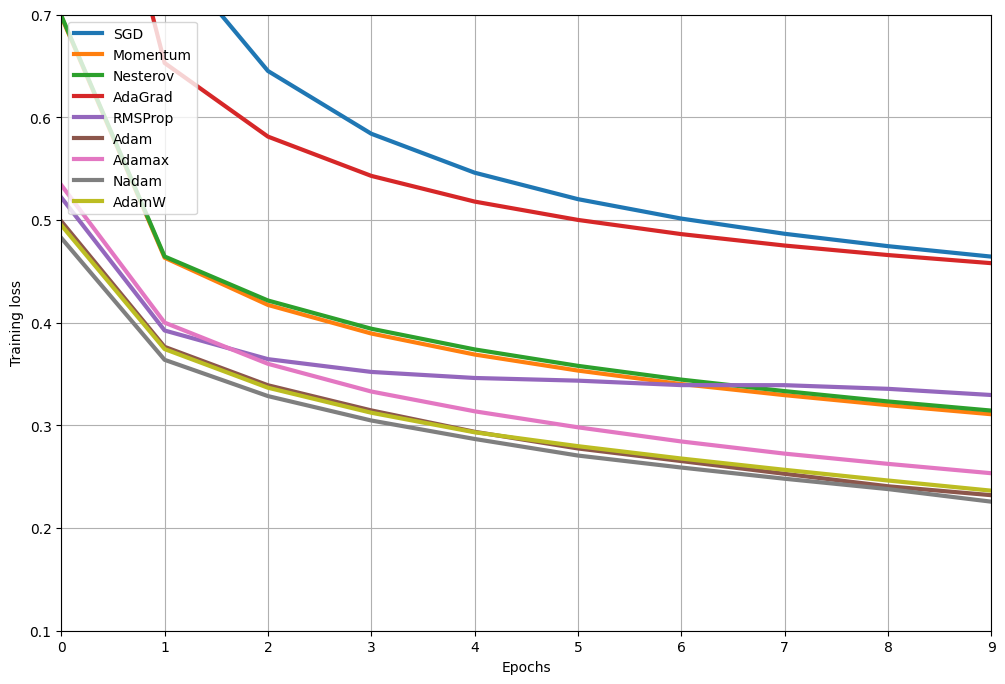

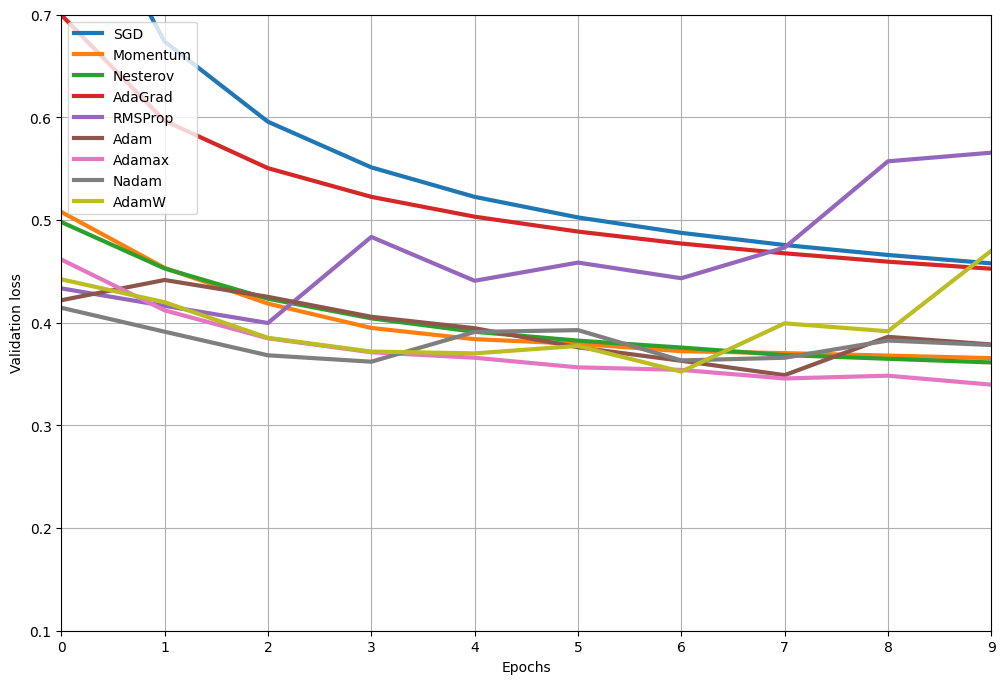

In [11]:
import matplotlib.pyplot as plt
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

### Exercise

Sometimes, adaptive optimizers fail, and non-adaptive optimizers like NAG or SGD perform a lot better.  This is sometimes the case with noisy data.

In the following, I've create a simple framework to examine the behavior of different optimizers with different noise levels.  Try running with an adaptive optimizer (AdamW) and a non-adaptive optimizer (NAG / SGD) with different levels of noise.  Do you find a point with NAG starts to outperform AdamW?  What happens if you adjust learning rates?

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add noise
noise_factor = 0.5
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

# Define a simple neural network model
def create_model(optimizer):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model
